Comparing Subreddits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

In [2]:
%store -r reddit_sent_df

In [3]:
sentiment_by_sub = reddit_sent_df.groupby(['covid_period', 'subreddit'])['compound'].mean().reset_index()

In [4]:
sentiment_by_sub['covid_period'] = pd.Categorical(sentiment_by_sub['covid_period'], 
                                                  categories=['Pre-COVID', 'During COVID', 'Post-COVID'], 
                                                  ordered=True)

In [5]:
sentiment_by_sub = sentiment_by_sub.sort_values('covid_period')

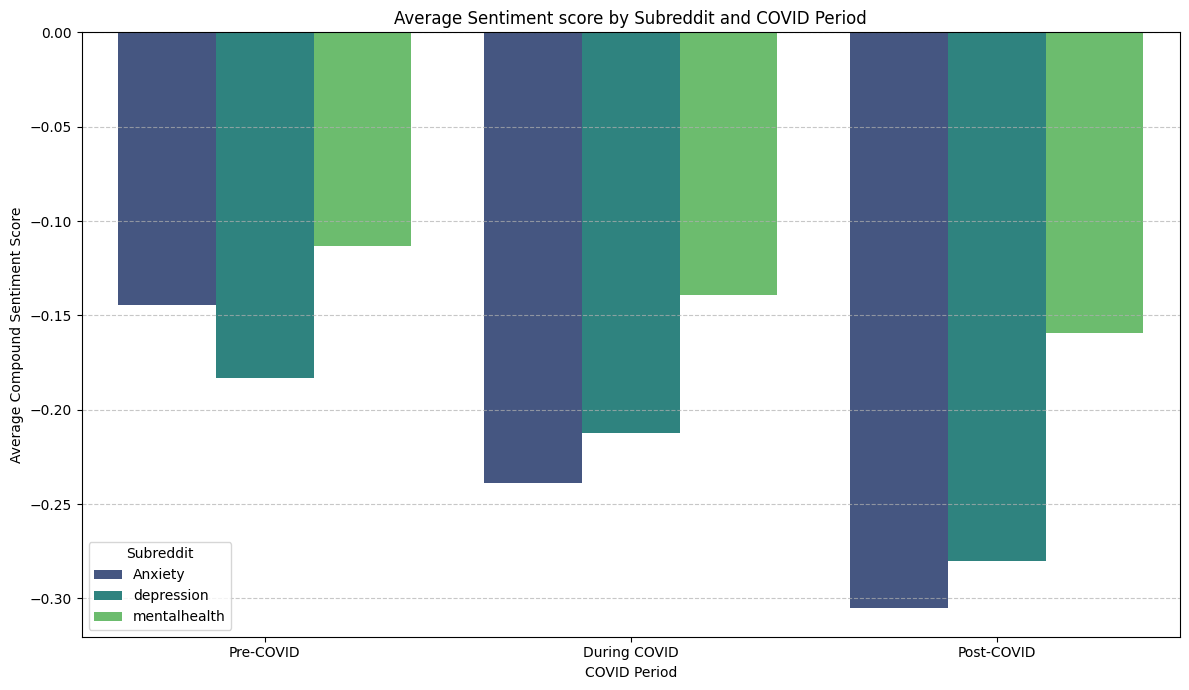

In [6]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=sentiment_by_sub,
    x='covid_period',
    y='compound',
    hue='subreddit',
    palette='viridis'
)

plt.title("Average Sentiment score by Subreddit and COVID Period")
plt.xlabel("COVID Period")
plt.ylabel("Average Compound Sentiment Score")
plt.legend(title="Subreddit")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

Keywords by Subreddit Analysis

In [17]:
stressor_terms = {
    'health_anxiety': ['heart', 'symptoms', 'panic attack', 'panic attacks', 'scared', 'pain', 'health', 'anxious', 'attack'],
    'work_stress': ['job', 'home', 'house', 'wfh', 'remote', 'work'],
    'school_stress': ['school', 'parents', 'mom', 'dad', 'remote school', 'class', 'online class'],
    'burnout': ['tired', 'anymore', 'hate', 'exhausted', 'fucking tired', 'end'],
    'therapy': ['therapist', 'therapy', 'counseling', 'telehealth', 'find help']
}
periods = ['Pre-COVID', 'During COVID', 'Post-COVID']

subreddits = reddit_sent_df['subreddit'].unique()
categories = list(stressor_terms.keys())
results = []


In [18]:
def count_total_words(text_series):
    if text_series.empty:
        return 0
    total_words = text_series.astype(str).str.split().str.len().sum()
    return total_words


# This function counts occurrences of a list of keywords
def count_keyword_mentions(text_series, keywords):
    if text_series.empty:
        return 0
    # Create a regex pattern: 'word1|word2|word3'
    pattern = r"\b(" + "|".join(re.escape(k) for k in keywords) + r")\b"
    mentions = text_series.astype(str).str.count(pattern, flags=re.IGNORECASE).sum()
    return int(mentions)

In [19]:
for period in periods:
    for sub in subreddits:
        # Create the subset of data
        subset_df = reddit_sent_df[
            (reddit_sent_df["covid_period"] == period)
            & (reddit_sent_df["subreddit"] == sub)
        ]

        if subset_df.empty:
            continue

        # Get all text and total words for this subset
        text_data = subset_df["full_text"]
        total_words = count_total_words(text_data)

        if total_words == 0:
            continue

        # Calculate frequency for each category
        for category, keywords in stressor_terms.items():
            mentions = count_keyword_mentions(text_data, keywords)
            # Calculate frequency per 1000 words
            freq_per_1000 = (mentions / total_words) * 1000 if total_words > 0 else 0

            # Store the result
            results.append(
                {
                    "covid_period": period,
                    "subreddit": sub,
                    "category": category,
                    "frequency_per_1000": freq_per_1000,
                    "total_mentions": mentions,
                    "total_words": total_words,
                }
            )

In [20]:
keyword_freq_df = pd.DataFrame(results)

/tmp/ipykernel_41450/249221658.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_41450/249221658.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_41450/249221658.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_41450/249221658.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_4

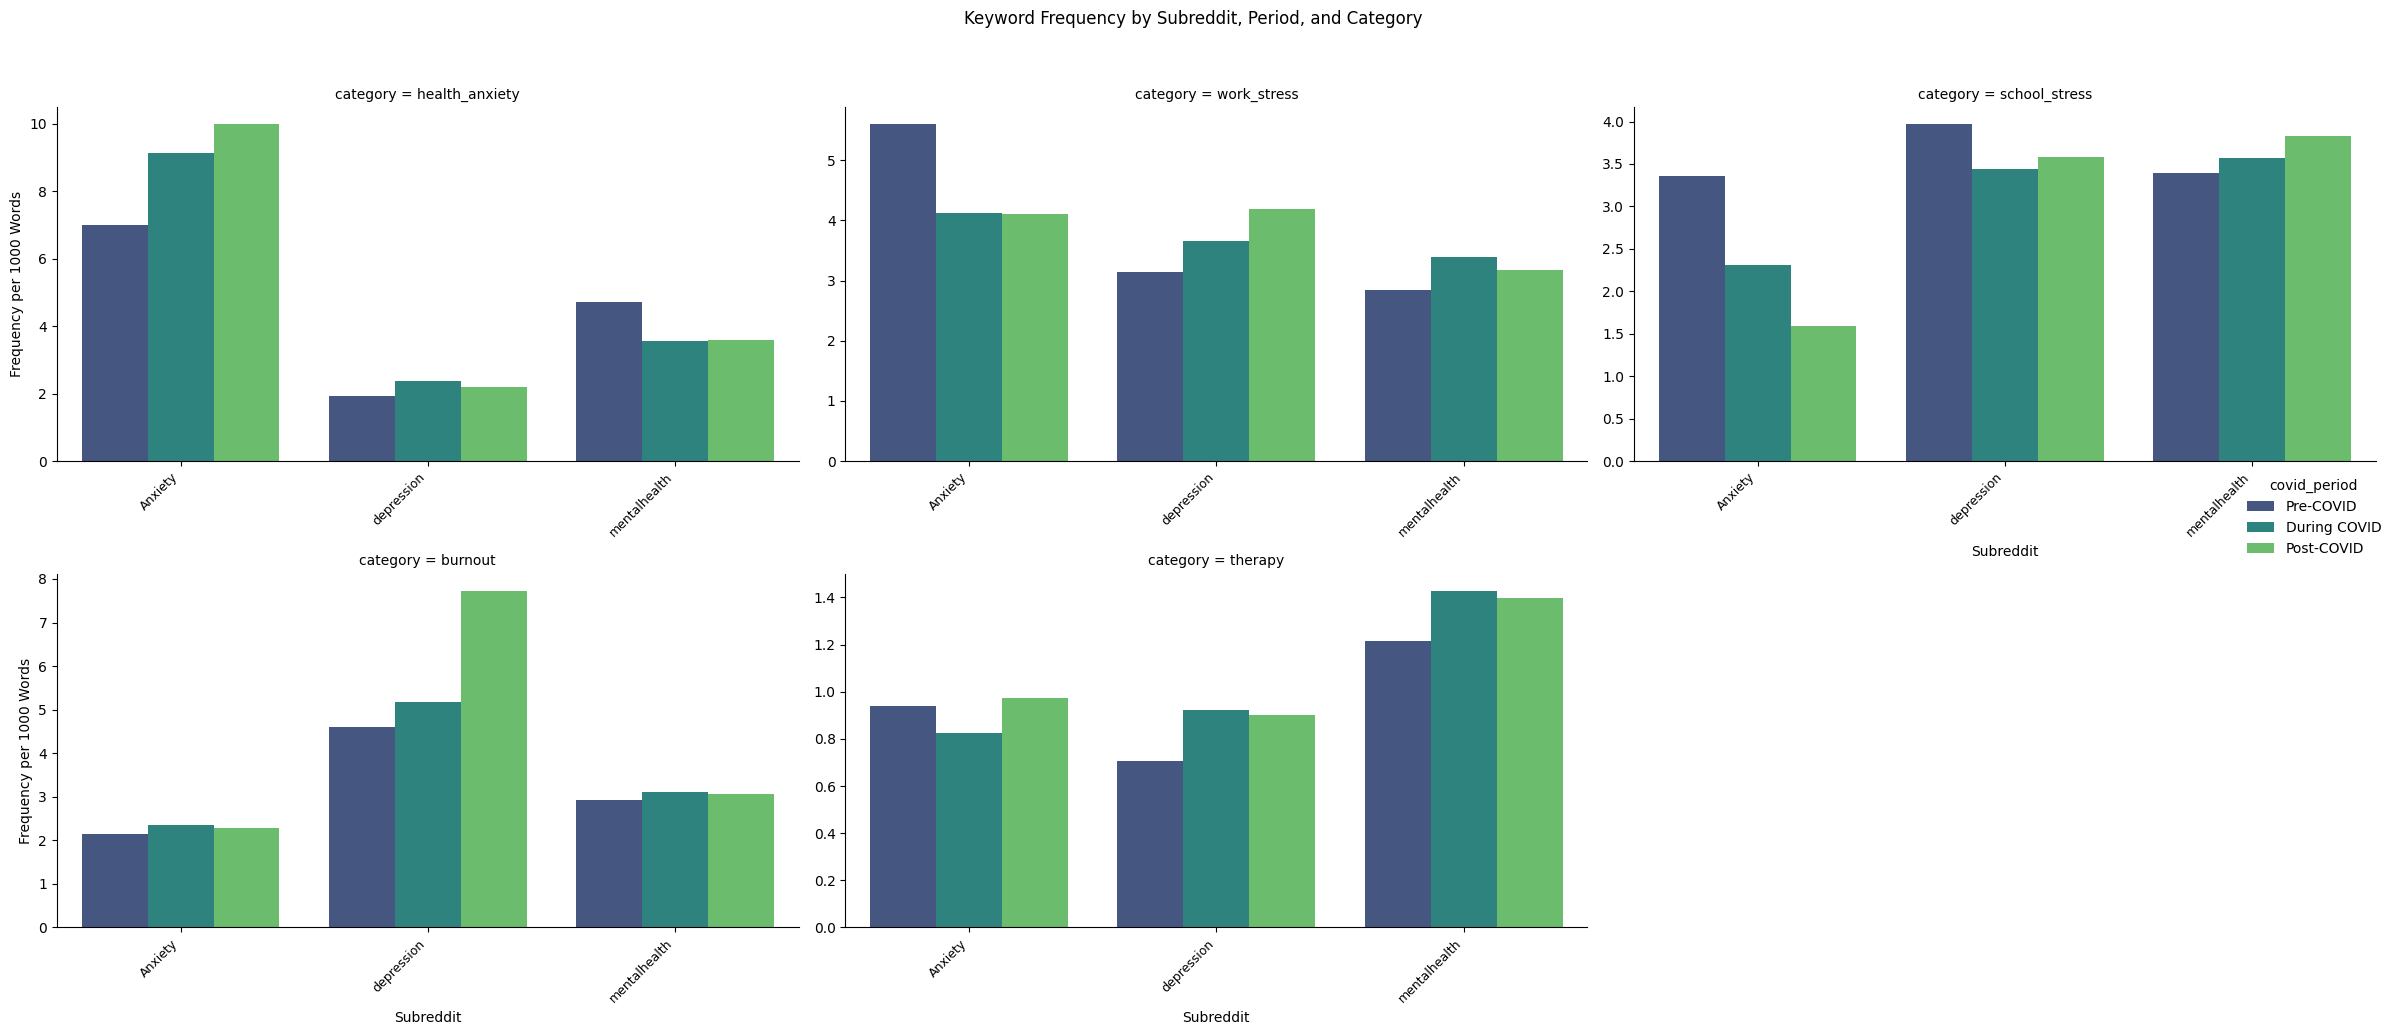

In [28]:
subreddit_order = sorted(keyword_freq_df['subreddit'].unique())

g = sns.catplot(
    data=keyword_freq_df,
    x="subreddit",
    y="frequency_per_1000",
    hue="covid_period",
    col="category",
    kind="bar",
    col_wrap=3,
    order=subreddit_order,
    palette="viridis",
    hue_order=["Pre-COVID", "During COVID", "Post-COVID"],
    height=5,
    aspect=1.5,
    sharex=False,
    sharey=False
)

for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

g.fig.suptitle("Keyword Frequency by Subreddit, Period, and Category", y=1.03)
g.set_axis_labels("Subreddit", "Frequency per 1000 Words")
# g.set_titles("{col_name}")
plt.tight_layout()
plt.show()